# Introduction

The purpose of this challenge is to use visitation data to predict the total number of restaurant visitors for future days.

#### Business background
One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

# Load Data

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import *
from xgboost import XGBRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:

STORE_INFO= pd.read_csv('air_store_info.csv')
STORE_INFO.rename(columns={'air_store_id':'store_id','air_genre_name':'genre_name','air_area_name':'area_name'},inplace=True)
VISIT_DATA= pd.read_csv('air_visit_data.csv', parse_dates=['visit_date'])
VISIT_DATA.rename(columns={'air_store_id':'store_id'},inplace=True)
DATE_INFO= pd.read_csv('date_info.csv', parse_dates=['calendar_date'])


### Visitors

In [3]:
VISIT_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
store_id      252108 non-null object
visit_date    252108 non-null datetime64[ns]
visitors      252108 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.8+ MB


In [4]:
VISIT_DATA.head()

,store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


### Store Info

In [5]:
STORE_INFO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
store_id      829 non-null object
genre_name    829 non-null object
area_name     829 non-null object
latitude      829 non-null float64
longitude     829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [6]:
STORE_INFO.head()

,store_id,genre_name,area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


### Date Info

In [7]:
DATE_INFO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
calendar_date    517 non-null datetime64[ns]
day_of_week      517 non-null object
holiday_flg      517 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.2+ KB


In [8]:
DATE_INFO.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


<a id='individual-feature-visualization'></a>

# Individual Feature Visualization

In [9]:
DATE_INFO.set_index('calendar_date', inplace=True)

In [10]:
df_holidays = DATE_INFO[DATE_INFO['holiday_flg'] == True]

In [11]:
df_holidays.head()

,day_of_week,holiday_flg
calendar_date,,
2016-01-01,Friday,1
2016-01-02,Saturday,1
2016-01-03,Sunday,1
2016-01-11,Monday,1
2016-02-11,Thursday,1


<a id='Air-Visits-2'></a>

## Visitors

In [12]:
# set DateTime index to perform visualizations
VISIT_DATA.set_index('visit_date', inplace=True)

#### STATISTICS ON NUMBER OF VISITORS PER DAY IN THE WHOLE TIME FRAME

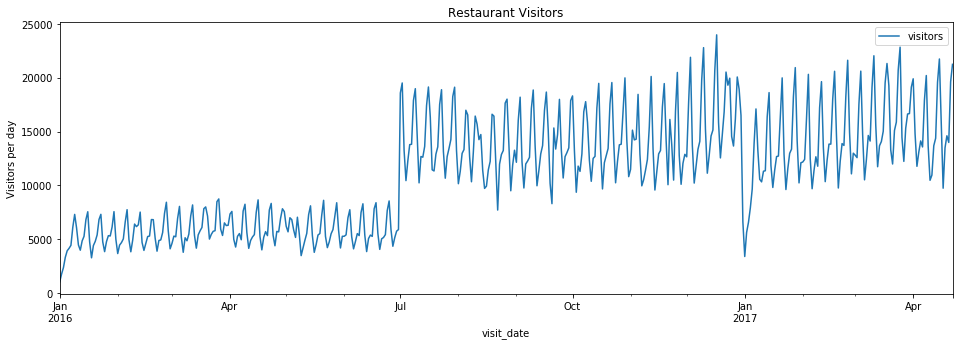

In [13]:
# display statistics per day
visits_daily = VISIT_DATA.resample('D').sum()
title='Restaurant Visitors'
ylabel='Visitors per day'

ax = visits_daily.plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);

### Holidays

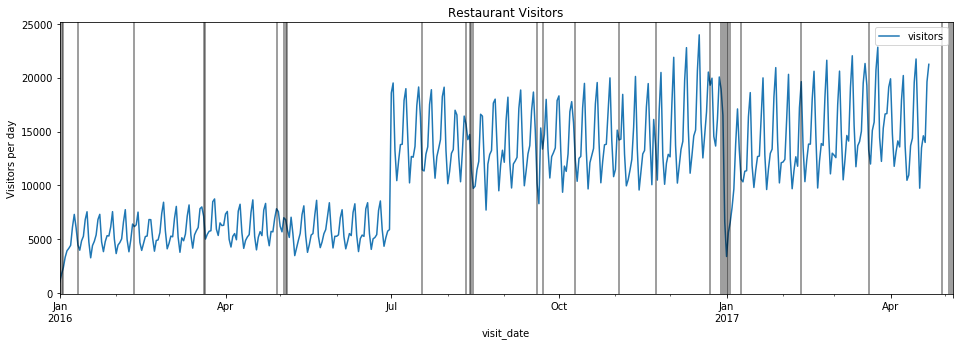

In [14]:
# display statistics per day
visits_daily =VISIT_DATA.resample('D').sum()
title='Restaurant Visitors'
ylabel='Visitors per day'

ax = visits_daily.plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);
for x in DATE_INFO.query('holiday_flg==1').index:
    ax.axvline(x=x, color='k', alpha = 0.5);

#### STATISTICS ON NUMBER OF VISITORS PER MONTH

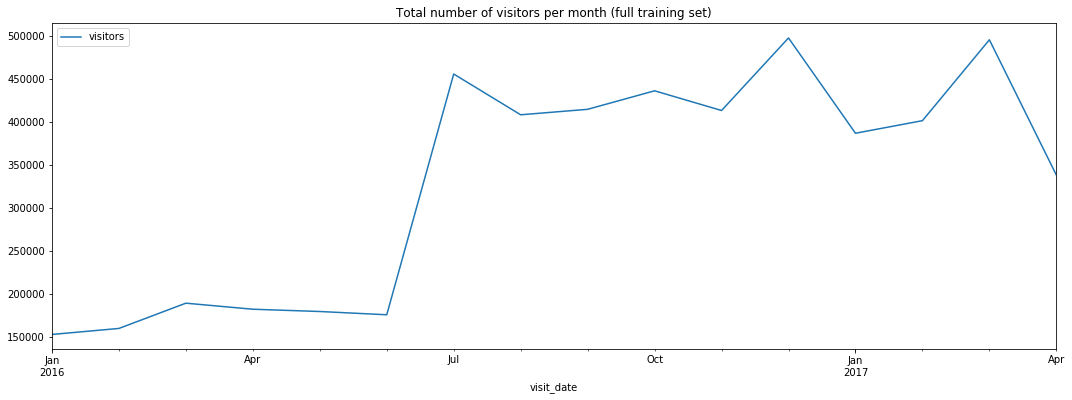

In [15]:
# display statistics per month
visits_monthly = VISIT_DATA.resample('M').sum()
ax = visits_monthly.plot(figsize=(18,6), title='Total number of visitors per month (full training set)');
title='Restaurant Visitors'
ylabel='Visitors per Month'

#### NUMBER OF VISITORS PER RESTAURANT PER WEEKDAY

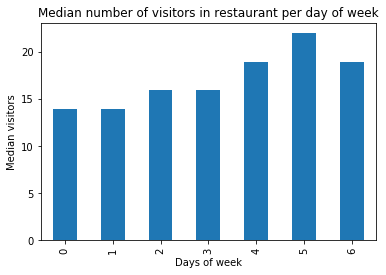

In [16]:
VISIT_DATA['visit_date'] = VISIT_DATA.index
VISIT_DATA['weekday'] = VISIT_DATA['visit_date'].dt.dayofweek

visits_per_weekday = VISIT_DATA[['weekday','visitors']].groupby(['weekday']).agg(['median'])

ax = visits_per_weekday.plot(kind='bar',legend=None)

ax.set_title("Median number of visitors in restaurant per day of week")
ax.set_xlabel("Days of week")
ax.set_ylabel("Median visitors");

### Store Info

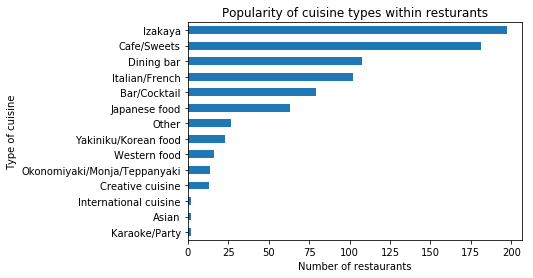

In [17]:
by_genre = STORE_INFO['genre_name'].value_counts()
      
# display data
ax = by_genre.plot(kind='barh');

# plot styling
plt.gca().invert_yaxis()

ax.set_title("Popularity of cuisine types within resturants")
ax.set_xlabel("Number of restaurants")
ax.set_ylabel("Type of cuisine");

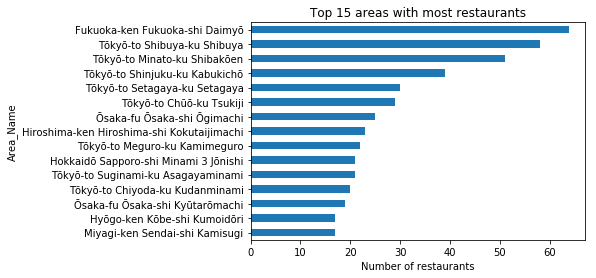

In [18]:
top_15_areas = STORE_INFO['area_name'].value_counts().head(15)

ax = top_15_areas.plot(kind='barh');

plt.gca().invert_yaxis()

ax.set_title("Top 15 areas with most restaurants")
ax.set_xlabel("Number of restaurants")
ax.set_ylabel("Area_Name");

In [19]:
data = {
    'tra': pd.read_csv('air_visit_data.csv').rename(columns={'air_store_id':'store_id'}),
    'as': pd.read_csv('air_store_info.csv').rename(columns={'air_store_id':'store_id','air_genre_name':'genre_name','air_area_name':'area_name'}),
    'hol': pd.read_csv('date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [20]:
data['tra'].head()

,store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [21]:
data['as'].head()

,store_id,genre_name,area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [22]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [23]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_day'] = data['tra']['visit_date'].dt.day
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [24]:
data['tra']

,store_id,visit_date,visitors,dow,year,month,visit_day
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,13
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,14
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,15
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,16
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,18
...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,18
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,19
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,20
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,21


In [25]:
unique_stores = data['tra']['store_id'].unique()
len(unique_stores)

829

In [26]:
stores = pd.concat([pd.DataFrame({'store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [27]:
stores.head()

,store_id,dow
0,air_ba937bf13d40fb24,0
1,air_25e9888d30b386df,0
2,air_8e4360a64dbd4c50,0
3,air_35512c42db0868da,0
4,air_a271c9ba19e81d17,0


In [28]:
data['as'].head()

,store_id,genre_name,area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [29]:
stores = pd.merge(stores, data['as'], how='left', on=['store_id'])

In [30]:
stores.head()

,store_id,dow,genre_name,area_name,latitude,longitude
0,air_ba937bf13d40fb24,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_25e9888d30b386df,0,Izakaya,Tōkyō-to Shinagawa-ku Higashigotanda,35.626568,139.725858
2,air_8e4360a64dbd4c50,0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025
3,air_35512c42db0868da,0,Dining bar,Tōkyō-to Musashino-shi Midorichō,35.717784,139.566260
4,air_a271c9ba19e81d17,0,Izakaya,Tōkyō-to Meguro-ku Kamimeguro,35.641463,139.698171


In [31]:
stores['genre_name'] = stores['genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['area_name'] = stores['area_name'].map(lambda x: str(str(x).replace('-',' ')))

In [32]:
stores

,store_id,dow,genre_name,area_name,latitude,longitude
0,air_ba937bf13d40fb24,0,Dining bar,Tōkyō to Minato ku Shibakōen,35.658068,139.751599
1,air_25e9888d30b386df,0,Izakaya,Tōkyō to Shinagawa ku Higashigotanda,35.626568,139.725858
2,air_8e4360a64dbd4c50,0,Cafe Sweets,Ōsaka fu Ōsaka shi Ōgimachi,34.705362,135.510025
3,air_35512c42db0868da,0,Dining bar,Tōkyō to Musashino shi Midorichō,35.717784,139.566260
4,air_a271c9ba19e81d17,0,Izakaya,Tōkyō to Meguro ku Kamimeguro,35.641463,139.698171
...,...,...,...,...,...,...
5798,air_168441ada3e878e1,6,Cafe Sweets,Hyōgo ken Kōbe shi Sumiyoshi Higashimachi,34.720228,135.265455
5799,air_6c952e3c6e590945,6,Yakiniku Korean food,Miyagi ken Sendai shi Kamisugi,38.269076,140.870403
5800,air_0f2f96335f274801,6,Izakaya,Tōkyō to Chiyoda ku Kanda Jinbōchō,35.695694,139.759386
5801,air_c7d30ab0e07f31d5,6,Other,Tōkyō to Taitō ku Higashiueno,35.712607,139.779996


In [33]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [34]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 

In [35]:
train = pd.merge(train, stores, how='left', on=['store_id','dow']) 

In [36]:
train.isnull().sum()

store_id       0
visit_date     0
visitors       0
dow            0
year           0
month          0
visit_day      0
day_of_week    0
holiday_flg    0
genre_name     0
area_name      0
latitude       0
longitude      0
dtype: int64

In [37]:
train=train.sort_values('visit_date')

In [38]:
train.head()

,store_id,visit_date,visitors,dow,year,month,visit_day,day_of_week,holiday_flg,genre_name,area_name,latitude,longitude
189299,air_fab092c35776a9b1,2016-01-01,19,4,2016,1,1,Friday,1,Cafe Sweets,Fukuoka ken Fukuoka shi Momochi,33.581941,130.348436
200675,air_f26f36ec4dc5adb0,2016-01-01,64,4,2016,1,1,Friday,1,Izakaya,Tōkyō to Shinjuku ku Kabukichō,35.693840,139.703549
213541,air_d97dabf7aae60da5,2016-01-01,102,4,2016,1,1,Friday,1,Cafe Sweets,Tōkyō to Shibuya ku Jingūmae,35.669290,139.707056
161915,air_39dccf7df20b1c6a,2016-01-01,55,4,2016,1,1,Friday,1,Izakaya,Hyōgo ken Takarazuka shi Tōyōchō,34.799767,135.360073
142213,air_79f528087f49df06,2016-01-01,42,4,2016,1,1,Friday,1,Western food,Tōkyō to Suginami ku Asagayaminami,35.699566,139.636438


In [39]:
train.reset_index(drop=True,inplace=True)

In [40]:
train.head()

,store_id,visit_date,visitors,dow,year,month,visit_day,day_of_week,holiday_flg,genre_name,area_name,latitude,longitude
0,air_fab092c35776a9b1,2016-01-01,19,4,2016,1,1,Friday,1,Cafe Sweets,Fukuoka ken Fukuoka shi Momochi,33.581941,130.348436
1,air_f26f36ec4dc5adb0,2016-01-01,64,4,2016,1,1,Friday,1,Izakaya,Tōkyō to Shinjuku ku Kabukichō,35.693840,139.703549
2,air_d97dabf7aae60da5,2016-01-01,102,4,2016,1,1,Friday,1,Cafe Sweets,Tōkyō to Shibuya ku Jingūmae,35.669290,139.707056
3,air_39dccf7df20b1c6a,2016-01-01,55,4,2016,1,1,Friday,1,Izakaya,Hyōgo ken Takarazuka shi Tōyōchō,34.799767,135.360073
4,air_79f528087f49df06,2016-01-01,42,4,2016,1,1,Friday,1,Western food,Tōkyō to Suginami ku Asagayaminami,35.699566,139.636438


In [41]:
train.drop(['day_of_week','latitude','longitude'],axis=1,inplace=True)
train.head()

,store_id,visit_date,visitors,dow,year,month,visit_day,holiday_flg,genre_name,area_name
0,air_fab092c35776a9b1,2016-01-01,19,4,2016,1,1,1,Cafe Sweets,Fukuoka ken Fukuoka shi Momochi
1,air_f26f36ec4dc5adb0,2016-01-01,64,4,2016,1,1,1,Izakaya,Tōkyō to Shinjuku ku Kabukichō
2,air_d97dabf7aae60da5,2016-01-01,102,4,2016,1,1,1,Cafe Sweets,Tōkyō to Shibuya ku Jingūmae
3,air_39dccf7df20b1c6a,2016-01-01,55,4,2016,1,1,1,Izakaya,Hyōgo ken Takarazuka shi Tōyōchō
4,air_79f528087f49df06,2016-01-01,42,4,2016,1,1,1,Western food,Tōkyō to Suginami ku Asagayaminami


In [42]:
train.to_csv('cleaned_data.csv')

In [43]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train['store_id'] = labelencoder.fit_transform(train['store_id'])
train['genre_name'] = labelencoder.fit_transform(train['genre_name'])
train['area_name'] = labelencoder.fit_transform(train['area_name'])

In [44]:
train.head()

,store_id,visit_date,visitors,dow,year,month,visit_day,holiday_flg,genre_name,area_name
0,812,2016-01-01,19,4,2016,1,1,1,2,3
1,791,2016-01-01,64,4,2016,1,1,1,7,77
2,705,2016-01-01,102,4,2016,1,1,1,2,73
3,173,2016-01-01,55,4,2016,1,1,1,7,31
4,383,2016-01-01,42,4,2016,1,1,1,12,79


In [45]:
X=train[['store_id','dow','year','month','visit_day','holiday_flg','genre_name','area_name']]
y=train['visitors']

In [46]:
train_len=int(len(train)*0.7)
train_len

176475

In [47]:
X_train=X[:train_len+1].values
y_train=y[:train_len+1].values
X_test=X[train_len+1:].values
y_test=y[train_len+1:].values

In [48]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)

In [49]:
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

In [50]:
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)

In [51]:
# model1.fit(X_train,y_train)
# model2.fit(X_train,y_train)
model3.fit(X_train, y_train)

[10:46:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       importance_type='gain', learning_rate=0.2, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=280,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=3,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [52]:
# preds1 = model1.predict(X_test)
# preds2 = model2.predict(X_test)
preds3 = model3.predict(X_test)

In [53]:
# print("RMSE GradientBoostingRegressor:",np.sqrt(metrics.mean_squared_error(y_test, preds1)))
# print("RMSE KNeighborsRegressor:",np.sqrt(metrics.mean_squared_error(y_test, preds2)))
print("RMSE XGBRegressor:",np.sqrt(metrics.mean_squared_error(y_test, preds3)))

RMSE XGBRegressor: 14.232066865121379


In [54]:
predictions=pd.DataFrame({'visit_date':train['visit_date'][train_len+1:],'pred_visitors':preds3.astype(int),'test_visitors':train['visitors'][train_len+1:]})

In [55]:
predictions=predictions.groupby('visit_date').sum()

In [56]:
predictions.head()

,pred_visitors,test_visitors
visit_date,,
2017-01-06,7343,7321
2017-01-07,17326,17101
2017-01-08,13845,13260
2017-01-09,12458,10566
2017-01-10,12356,10327


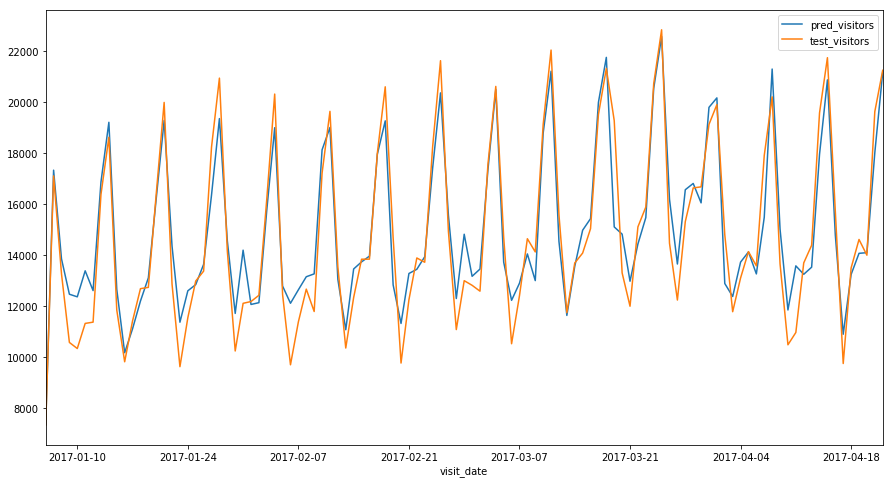

In [57]:
predictions.plot(figsize=(15,8))